In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/non-fulfillment/sample_submission.csv
/kaggle/input/non-fulfillment/train.csv
/kaggle/input/non-fulfillment/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score

# 딥러닝 모델 (TensorFlow)
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv("/kaggle/input/non-fulfillment/train.csv")
test_df = pd.read_csv("/kaggle/input/non-fulfillment/test.csv")

# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [4]:
categorical_cols = ["주거 형태", "현재 직장 근속 연수", "대출 목적", "대출 상환 기간"]

# 라벨 인코딩 (현재 직장 근속 연수)
label_enc = LabelEncoder()
X["현재 직장 근속 연수"] = label_enc.fit_transform(X["현재 직장 근속 연수"])
test_df["현재 직장 근속 연수"] = label_enc.transform(test_df["현재 직장 근속 연수"])

# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)

In [5]:
# 로그 변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for col in log_columns:
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [6]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

In [7]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

In [8]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

🔄 Fold 1 시작
Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5012 - loss: 0.6999 - val_accuracy: 0.5053 - val_loss: 0.6906
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5085 - loss: 0.6948 - val_accuracy: 0.5611 - val_loss: 0.6879
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5228 - loss: 0.6911 - val_accuracy: 0.5899 - val_loss: 0.6859
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5263 - loss: 0.6916 - val_accuracy: 0.6024 - val_loss: 0.6842
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5382 - loss: 0.6888 - val_accuracy: 0.6077 - val_loss: 0.6825
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5324 - loss: 0.6877 - val_accuracy: 0.6036 - val_loss: 0.6810
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5589 - loss: 0.6850 - val_accuracy: 0.6066 - val_loss: 0.6794
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5522 - loss: 0.684

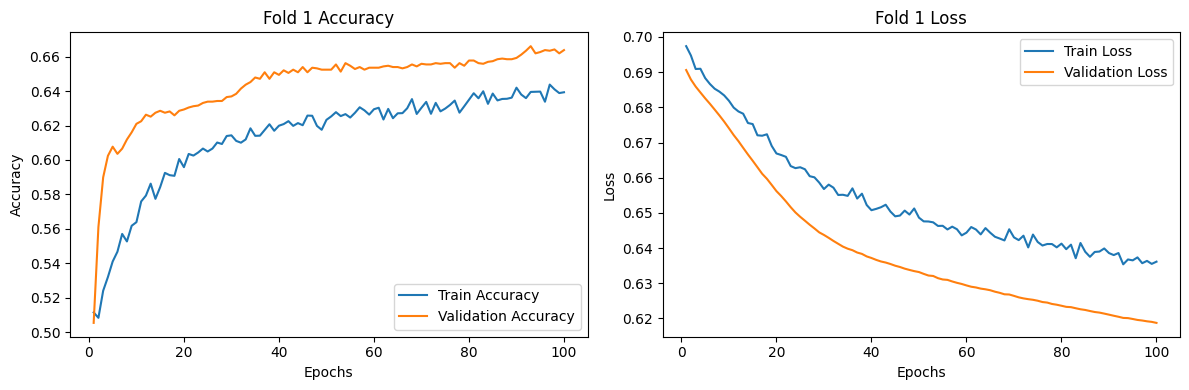

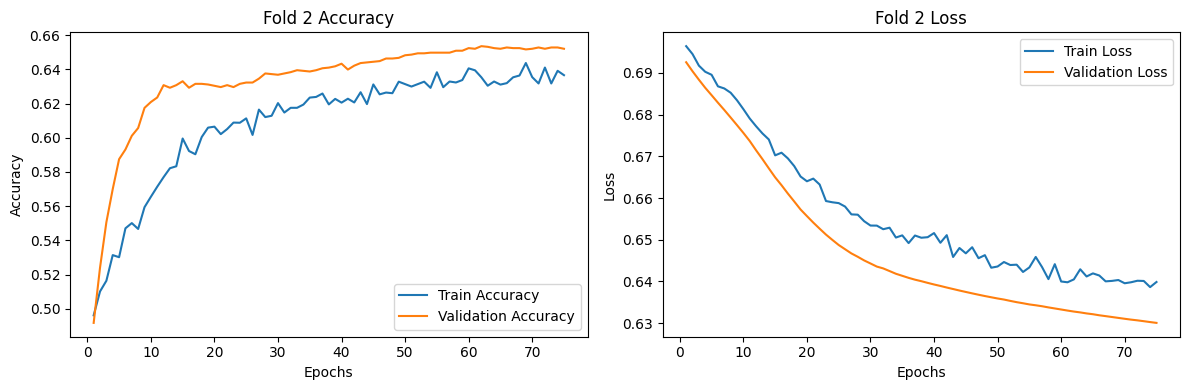

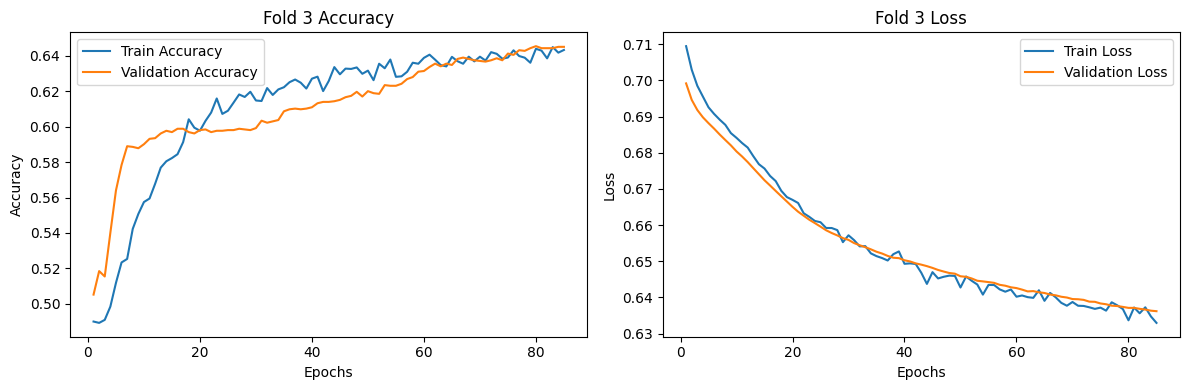

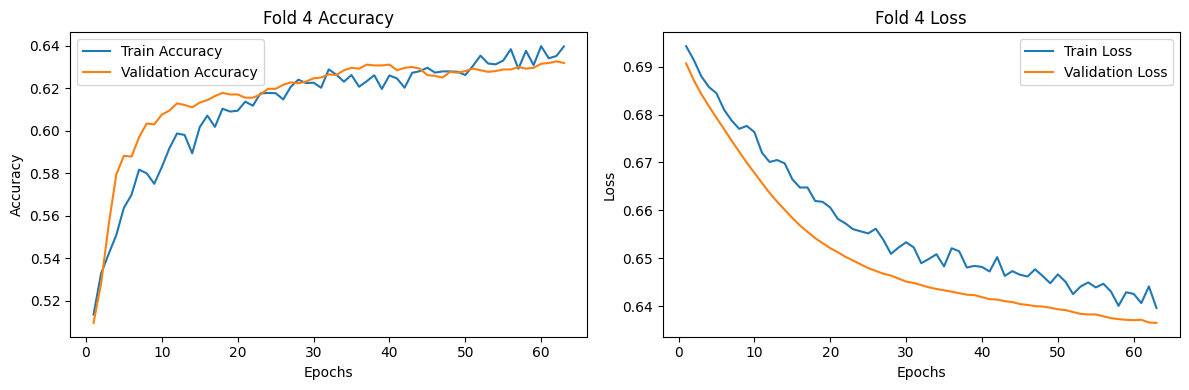

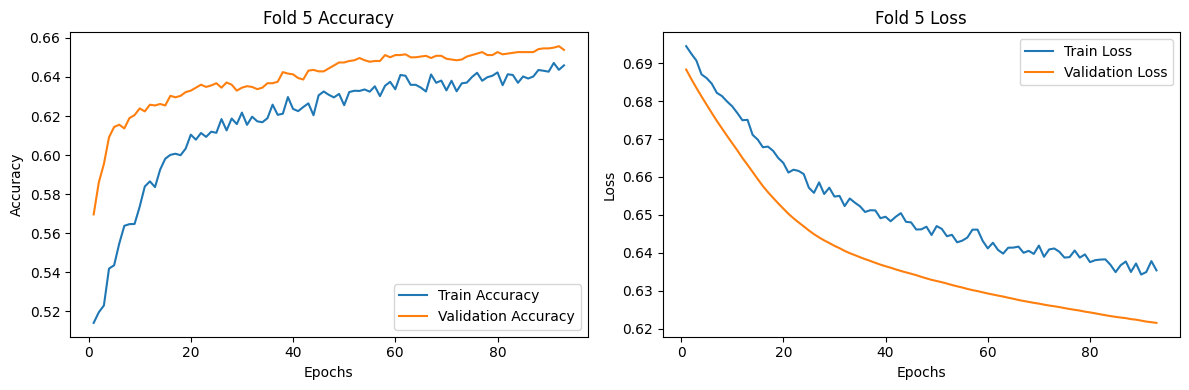

In [9]:
# Fold별 Accuracy와 Loss 저장용 리스트 초기화
all_history = []  # 이 줄을 추가하여 all_history를 명확히 초기화합니다.

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"🔄 Fold {fold} 시작")

    # 학습/검증 데이터 분리
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    # 모델 정의
    model = keras.Sequential([
        keras.layers.Dense(128, activation="relu", input_shape=(X_train_fold.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # 조기 종료 콜백 설정
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_valid_fold, y_valid_fold),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fold의 학습 결과 저장
    all_history.append(history.history)  # Fold별 학습 결과 저장

    # 검증 데이터 예측 및 평가
    y_valid_pred = model.predict(X_valid_fold).flatten()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold {fold} Validation ROC-AUC: {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

# 교차검증 평균 결과 출력
print(f"✅ 교차검증 평균 ROC-AUC: {np.mean(roc_auc_scores):.4f}")

# 시각화: Fold별 Accuracy와 Loss
for i, history in enumerate(all_history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
y_test_pred = model.predict(test_scaled).flatten()  # 확률 값 그대로 사용

# 제출 파일 생성
submission = pd.DataFrame({
    "UID": test_uid["UID"],
    "채무 불이행 확률": y_test_pred  # 확률값을 그대로 저장
})

# CSV 저장
submission.to_csv("submission_17th.csv", index=False)

print("✅ 제출 파일 생성 완료! 'submission_17th.csv' 저장되었습니다.")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ 제출 파일 생성 완료! 'submission_17th.csv' 저장되었습니다.
